In [1]:
import json
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

# Define feature extraction function
def extract_features(parsed_plan):
    features = defaultdict(float)
    op_counts = defaultdict(int)
    numerical_features = defaultdict(list)
    max_depth = 0

    def traverse(node, depth=1):
        nonlocal max_depth
        max_depth = max(max_depth, depth)

        params = node.get('plan_parameters', {})
        op_name = params.get('op_name', 'Unknown')
        op_counts[op_name] += 1

        numerical_features['est_startup_cost'].append(params.get('est_startup_cost', 0.0))
        numerical_features['est_cost'].append(params.get('est_cost', 0.0))
        numerical_features['est_card'].append(params.get('est_card', 0.0))
        numerical_features['est_width'].append(params.get('est_width', 0.0))
        numerical_features['workers_planned'].append(params.get('workers_planned', 0.0))
        numerical_features['est_children_card'].append(params.get('est_children_card', 0.0))

        for child in node.get('children', []):
            traverse(child, depth + 1)

    traverse(parsed_plan)

    for op, count in op_counts.items():
        features[f'op_count_{op}'] = count

    for feature, values in numerical_features.items():
        features[f'{feature}_sum'] = sum(values)
        features[f'{feature}_mean'] = np.mean(values) if values else 0.0
        features[f'{feature}_max'] = max(values) if values else 0.0
        features[f'{feature}_min'] = min(values) if values else 0.0

    features['tree_depth'] = max_depth
    features['num_nodes'] = len(numerical_features['est_cost'])

    return features

/home/wuy/software/anaconda3/envs/zsce/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
with open('../tpch_data/val_plans.json') as f:
    parsed_plans = json.load(f)

feature_dicts=[]
labels = []
for plan in tqdm(parsed_plans['parsed_plans']):
    features = extract_features(plan)
    feature_dicts.append(features)
    labels.append(plan.get('peakmem', 0.0))  # Replace with actual peak memory field

In [7]:
# Create DataFrame
df_features = pd.DataFrame(feature_dicts)
df_labels = pd.Series(labels, name='peakmem')

# Handle missing values
df_features.fillna(0, inplace=True)

In [8]:
df_features

,op_count_Finalize Aggregate,op_count_Gather,op_count_Partial Aggregate,op_count_Hash Join,op_count_Parallel Seq Scan,op_count_Hash,op_count_Index Only Scan,est_startup_cost_sum,est_startup_cost_mean,est_startup_cost_max,...,op_count_Parallel Bitmap Heap Scan,op_count_Bitmap Index Scan,op_count_Parallel Index Scan,op_count_Bitmap Heap Scan,op_count_Parallel Index Only Scan,op_count_BitmapAnd,op_count_Merge Join,op_count_Sort,op_count_Memoize,op_count_Materialize
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,86433.66,12347.665714,28922.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.50,0.750000,1.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,2.0,0.0,0.0,715394.36,79488.262222,214540.12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,1.0,0.0,2.0,621509.28,51792.440000,182358.12,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,2.0,0.0,0.0,295467.91,49244.651667,192745.39,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12419,1.0,1.0,1.0,0.0,3.0,0.0,0.0,671260.90,67126.090000,193724.73,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12420,1.0,1.0,1.0,0.0,2.0,0.0,1.0,626932.90,52244.408333,175546.58,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12421,1.0,1.0,1.0,3.0,3.0,3.0,0.0,1020032.19,53685.904737,196867.68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12422,1.0,1.0,1.0,2.0,0.0,2.0,0.0,22814.60,1901.216667,7673.41,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Encode categorical features (if any)
# Assuming 'op_count_*' are categorical; adjust based on actual data
op_count_features = [col for col in df_features.columns if col.startswith('op_count_')]
# If they are counts, you might treat them as numerical
# Otherwise, use label encoding or one-hot encoding as needed

# Feature scaling (optional)
scaler = StandardScaler()
numerical_cols = [col for col in df_features.columns if any(sub in col for sub in ['est_startup_cost', 'est_cost', 'est_card', 'est_width', 'workers_planned', 'est_children_card'])]
df_features[numerical_cols] = scaler.fit_transform(df_features[numerical_cols])

In [11]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.2, random_state=42)

In [19]:
len(X_train.columns)

49

In [12]:
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

# Train the model
xgb_reg.fit(X_train, y_train)

# Predict on test set
y_pred = xgb_reg.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.2f}")
print(f"Test R² Score: {r2:.2f}")

Test MSE: 859929969.78
Test R² Score: 0.75


After training, analyze feature importances to understand which features most significantly impact peak memory usage predictions.

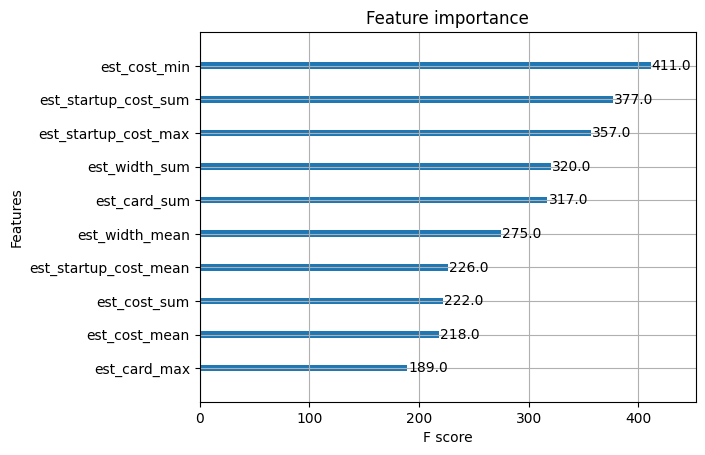

In [13]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot feature importances
xgb.plot_importance(xgb_reg, max_num_features=10)
plt.show()


In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

def compute_metrics(y_test, y_pred):
    """
    Compute various regression metrics between y_test and y_pred.

    Parameters:
    - y_test (np.array): True values.
    - y_pred (np.array): Predicted values.

    Returns:
    - metrics (dict): Dictionary containing all computed metrics.
    """
    # Ensure inputs are NumPy arrays
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    
    # Avoid division by zero by adding a small epsilon where necessary
    epsilon = 1e-10
    y_test_safe = np.where(y_test == 0, epsilon, y_test)
    y_pred_safe = np.where(y_pred == 0, epsilon, y_pred)
    
    # Q-Error Calculation
    qerror = np.maximum(y_pred_safe / y_test_safe, y_test_safe / y_pred_safe)
    
    # Q-Error Metrics
    qerror_min = np.min(qerror)
    qerror_50 = np.percentile(qerror, 50)
    qerror_90 = np.percentile(qerror, 90)
    qerror_95 = np.percentile(qerror, 95)
    qerror_99 = np.percentile(qerror, 99)
    qerror_max = np.max(qerror)
    mean_qerror = np.mean(qerror)
    
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Mean Relative Error (MRE)
    mre = np.mean(np.abs((y_pred - y_test) / y_test_safe))
    
    # Compile all metrics into a dictionary
    metrics = {
        'qerror_min': qerror_min,
        'qerror_50 (Median)': qerror_50,
        'qerror_90': qerror_90,
        'qerror_95': qerror_95,
        'qerror_99': qerror_99,
        'qerror_max': qerror_max,
        'mean_qerror': mean_qerror,
        'mae': mae,
        'mre': mre
    }
    
    return metrics


In [16]:
metrics = compute_metrics(y_test, y_pred)
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

qerror_min: 1.0001
qerror_50 (Median): 1.1703
qerror_90: 2.1932
qerror_95: 2.9809
qerror_99: 5.3384
qerror_max: 9.2180
mean_qerror: 1.4606
mae: 18836.8979
mre: 0.4095
